# Import Libraries

In [121]:
import os
import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import seaborn as sns
import keras
import numpy as np
from tensorflow import keras
# import tensorflow_addons as tfa     #pip install -U tensorflow-addons
import pandas as pd

%load_ext autoreload
%autoreload 2

# Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# from keras_tqdm import TQDMNotebookCallback      #!pip install keras-tqdm

# Keras-Tuner
# from kerastuner.tuners import RandomSearch

import cv2 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# CNN Class and methods
from src.model_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# !pip install -U tensorflow-addons

In [7]:
'''
   CNN Layers for builing models
'''
CONV2D_3x3_32 = 'Conv2D3x3_32'
CONV2D_3x3_64 = 'Conv2D3x3_64'
CONV2D_3x3_128 = 'Conv2D3x3_128'
CONV2D_2x2_32 = 'Conv2D2x2_32'
CONV2D_2x2_64 = 'Conv2D2x2_64'
CONV2D_2x2_128 = 'Conv2D2x2_128'

BATCH_NORMAL = 'BatchNormal'
MAXPOOL_2D = 'MaxPool2D'
DROPOUT_10PERCENT = 'DropOut_10percent'
DROPOUT_20PERCENT = 'DropOut_20percent'
FLATTEN_LAYERS = 'Flatten_layers'
DENSE = 'Dense'
DENSE_512 = 'Dense512'

# Description of the Pneumonia Dataset
- The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). 
- There are 5,216 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). 

# Load Dataset

In [37]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [38]:
train = get_training_data('../../data/chest_xray/train')
test = get_training_data('../../data/chest_xray/test')
val = get_training_data('../../data/chest_xray/val')

<ipython-input-37-b2613b36a4a4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


# Data Visualization and Preprocessing

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in a

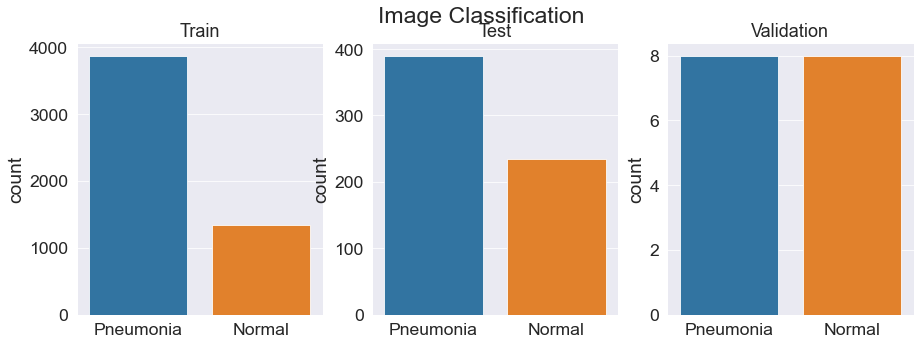

In [123]:
lst_train = lst_test = lst_val = []
for i in train:
    if(i[1] == 0):
        lst_train.append("Pneumonia")
    else:
        lst_train.append("Normal")
        
lst_test = []
for i in test:
    if(i[1] == 0):
        lst_test.append("Pneumonia")
    else:
        lst_test.append("Normal")       
        
lst_val = []
for i in val:
    if(i[1] == 0):
        lst_val.append("Pneumonia")
    else:
        lst_val.append("Normal") 

fig, ax = plt.subplots(1,3,figsize=(15,5))
fig.suptitle("Image Classification\n")
sns.set_style('darkgrid')
sns.set_context("paper", font_scale=2.0)

ss0 = sns.countplot(lst_train, ax=ax[0])  
ax[0].set_title("Train",fontsize=18)

ss1= sns.countplot(lst_test, ax=ax[1])  
ax[1].set_title("Test",fontsize=18)

ss2 = sns.countplot(lst_val, ax=ax[2])  
ax[2].set_title("Validation",fontsize=18)

plt.savefig('../../visualization/image_classification.png', dpi=300)

## Let's visualize couple of images

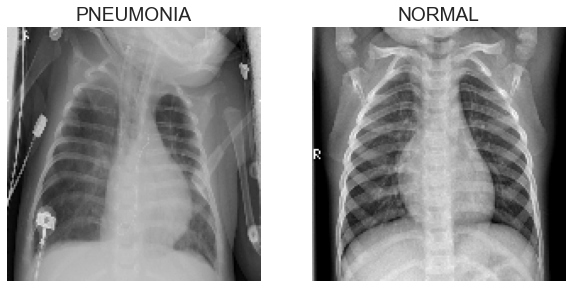

In [124]:
figure = plt.figure(figsize=(10,10))
figure.add_subplot(1, 2, 1)

plt.imshow(train[0][0], cmap='gray'), plt.axis("off")
plt.title(labels[train[0][1]])

figure.add_subplot(1, 2, 2)
plt.imshow(train[-1][0], cmap='gray'), plt.axis("off")
plt.title(labels[train[-1][1]])
plt.savefig('../../visualization/sample_Xrays.png', dpi=300)
plt.show()

## Merge separate x_train,y_train and X_test,y_test and x_val,y_val into three datasets
- X_train is train dataset
- X_test is test dataset
- y_test is validation dataset

In [41]:
'''
    Merge train and test datasets combining both NORMAL and PNEUMONIA X-Rays
'''
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

## Perform Greyscale Normalization

In [42]:
'''
    Perform grayscale normalization
'''
# Normalize data
X_train = np.array(X_train, dtype=int) / 255
X_val = np.array(X_val, dtype=int) / 255
X_test = np.array(X_test, dtype=int) / 255

## Resize data to prepare for running CNN models

In [43]:
'''
    Resize data for deep learning
''' 
X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [16]:
'''
    Augment dataset, because of class imbalance
    Function augment_images is under src/model_utils
'''
datagen = augment_images(X_train)

# Run FSM
- 1) Call cnn_model utility to intantiate the model.
   cnn_model also sets the default parameters and hyperparameters for construcing CNN layers
- 2) Build model.
   Build_model takes twoa list of steps as input.
   Model is built in the order of the steps defined as constants strings.

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
flatten_37 (Flatten)         (None, 720000)            0         
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 720001    
Total params: 720,321
Trainable params: 720,321
Non-trainable params: 0
_________________________________________________________________
{'loss': [1.2712219953536987, 0.3674940764904022, 0.31134700775146484, 0.24336394667625427, 0.2260156124830246, 0.22099056839942932, 0.21944119036197662, 0.21104803681373596, 0.19932979345321655, 0.20271189510822296, 0.19311487674713135, 0.18524645268917084, 0.1836206316947937, 0.18188464641571045, 0.18090449273586273, 0.18921224772930145, 0.1874021589756012, 0.1854161769151

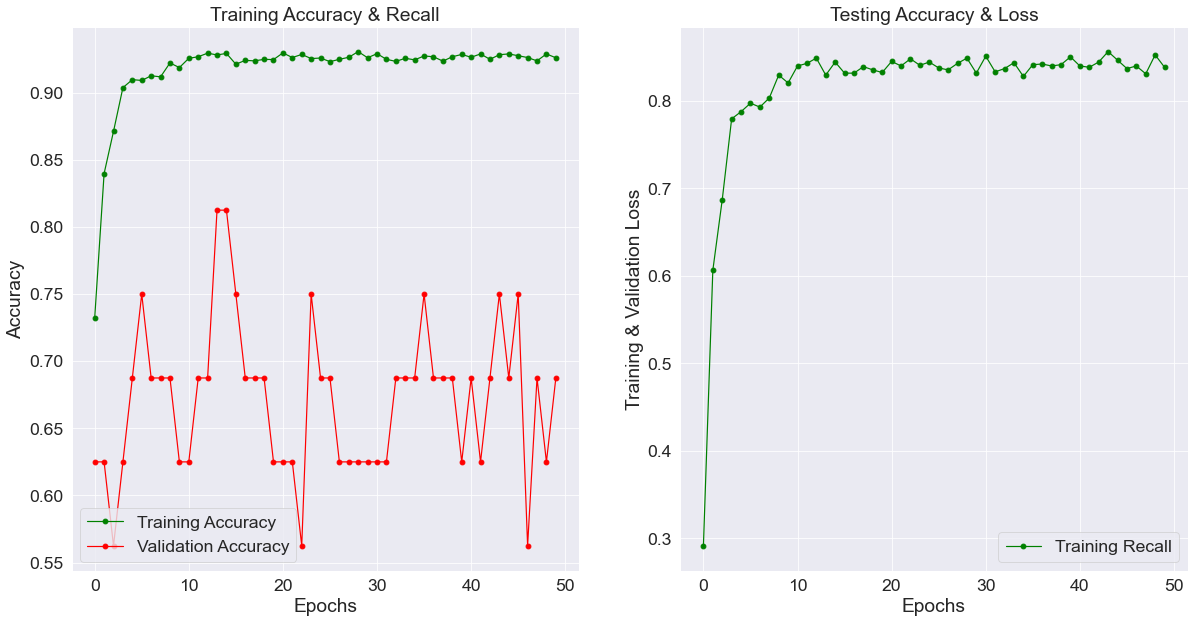

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.87      0.95      0.91       390
   Normal (Class 1)       0.90      0.76      0.83       234

           accuracy                           0.88       624
          macro avg       0.89      0.86      0.87       624
       weighted avg       0.88      0.88      0.88       624

[[371  19]
 [ 55 179]]
Sample of Penumonia X-rays
sample Normal X_rays


<Figure size 432x288 with 0 Axes>

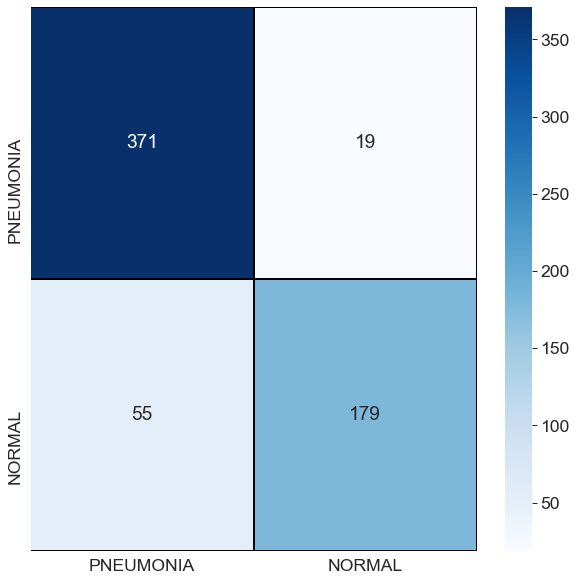

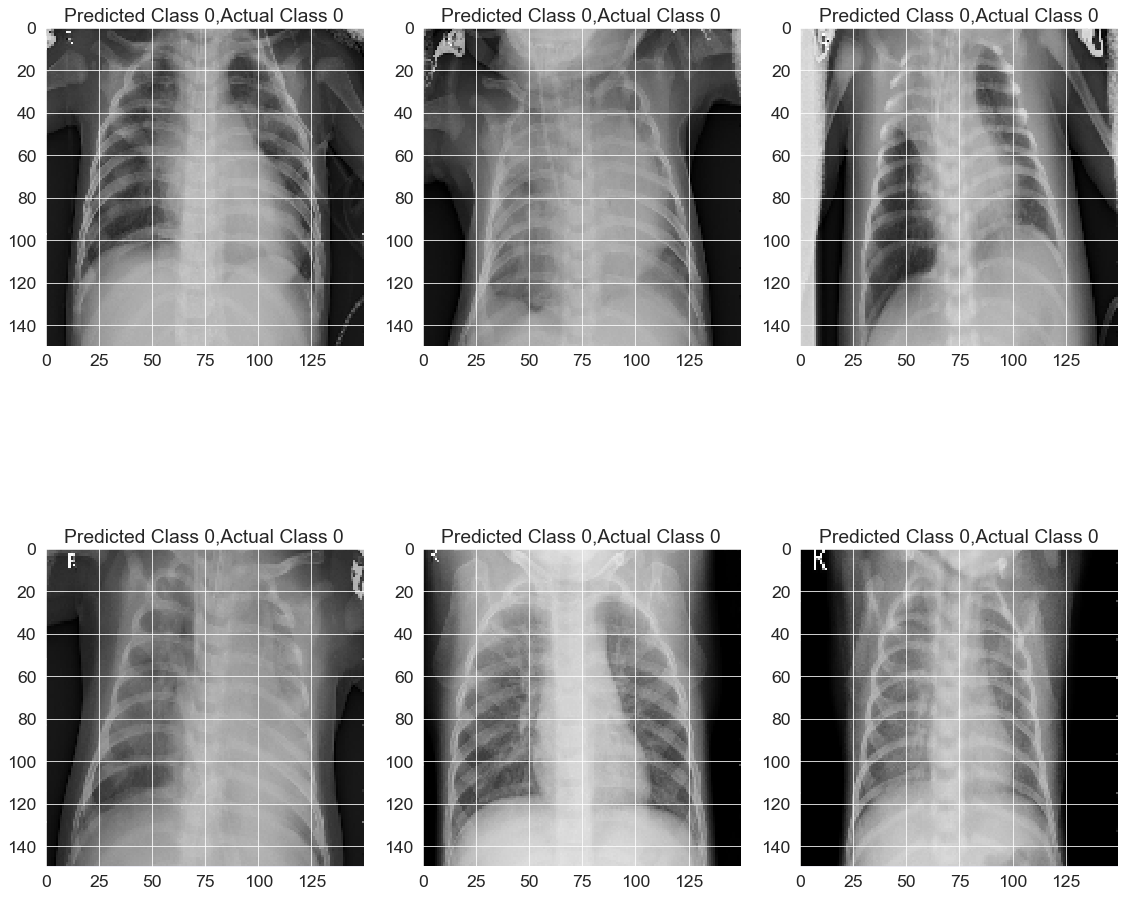

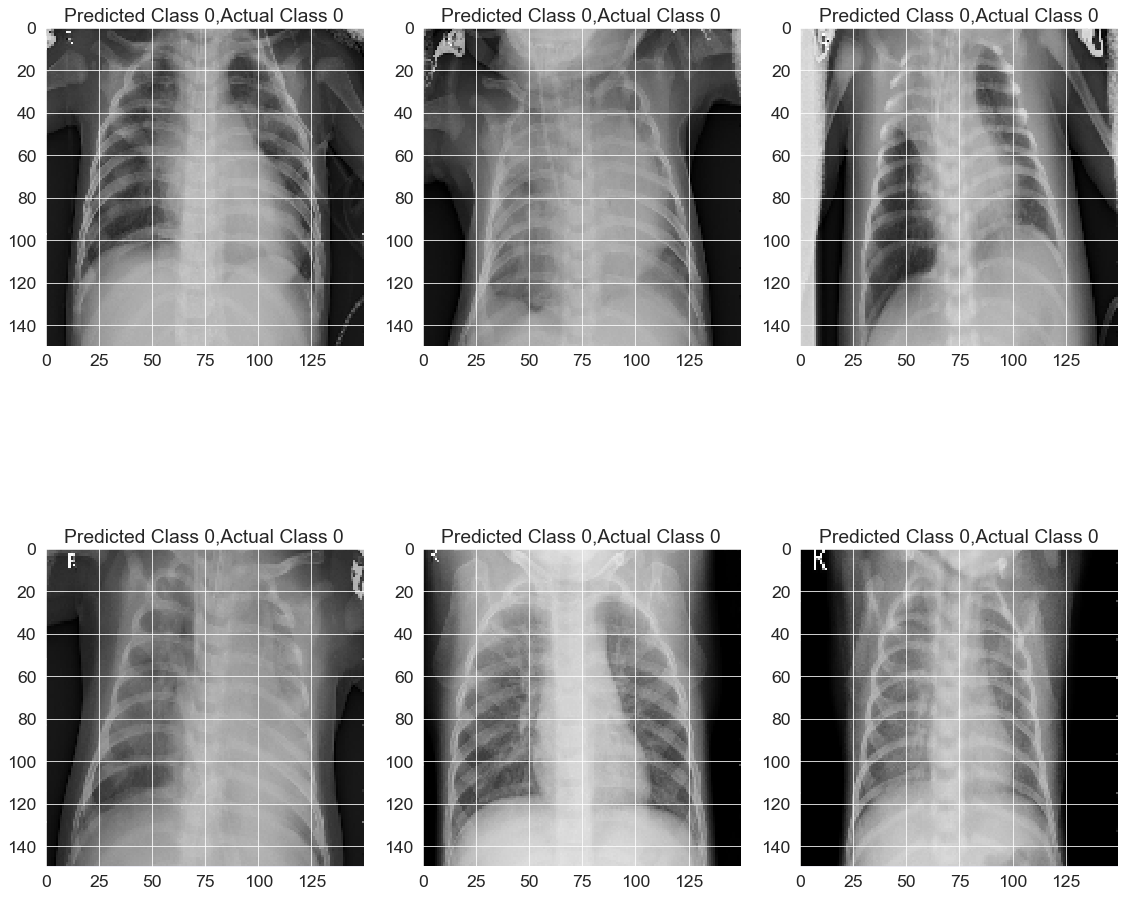

In [117]:
'''
    First Simple Model
    CNN Layers: Conv2D, 32 units, 3x3 filter | Flatten Layers | Dense Output Layer
    Epochs: 50
'''
# Intantial cnn_model class and store all datasets inside the class
cnn  = cnn_model(X_train, y_train, X_test, y_test, X_val, y_val)
model = cnn.build_model([CONV2D_3x3_32, FLATTEN_LAYERS])
history = cnn.fit_report_model("FSM_", 32, 50)

# Run more complex model to improve on accuracy
    Funciton: fit_and_report 
    1) Build models by sequencing various layer methods.
    2) Final layer is set 1 and with Sigmoid.
    3) Print Confustion Matrix
    4) Sample X-Rays from Pneumonia and Normal pool

# Model 1: 


# Model 2: 


# Model 3: Reproduce the Best Model from Paul`

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 92416)             0         
_________________________________________________________________
dense_75 (Dense)             (None, 128)               11829376  
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)             

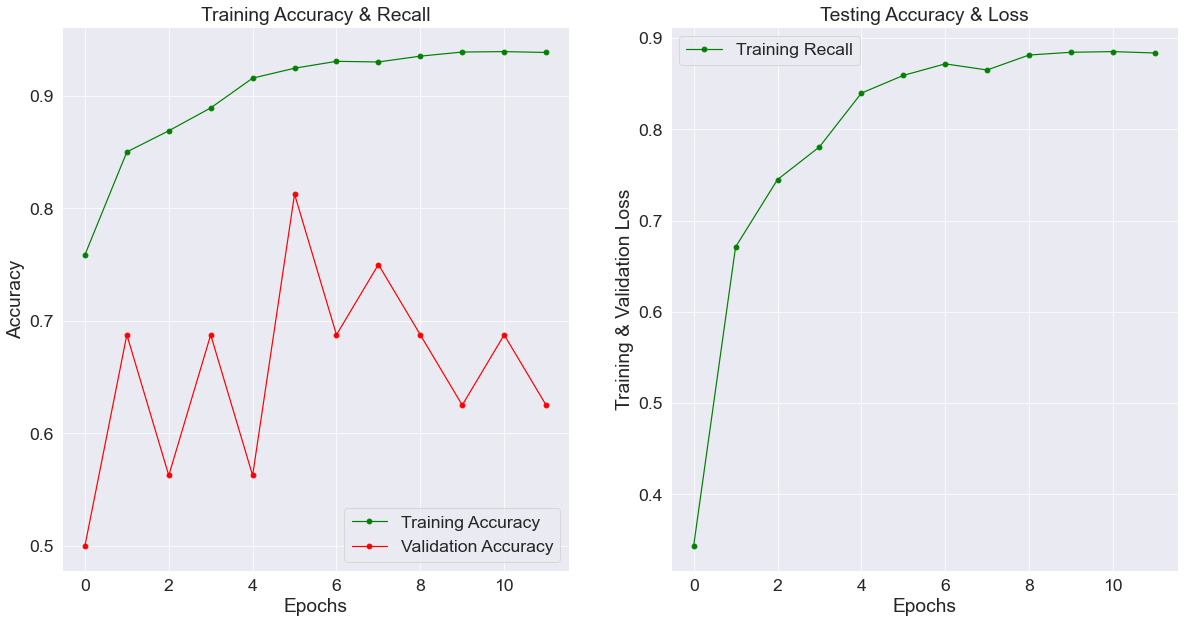

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.97      0.93       390
   Normal (Class 1)       0.94      0.82      0.87       234

           accuracy                           0.91       624
          macro avg       0.92      0.89      0.90       624
       weighted avg       0.91      0.91      0.91       624

[[377  13]
 [ 43 191]]
Sample of Penumonia X-rays
sample Normal X_rays


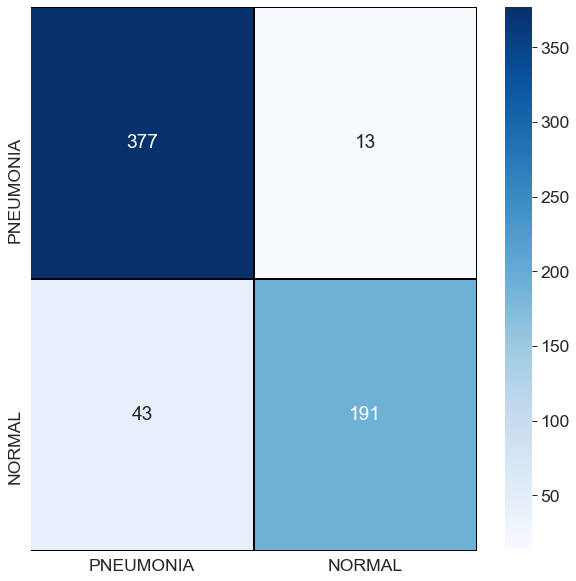

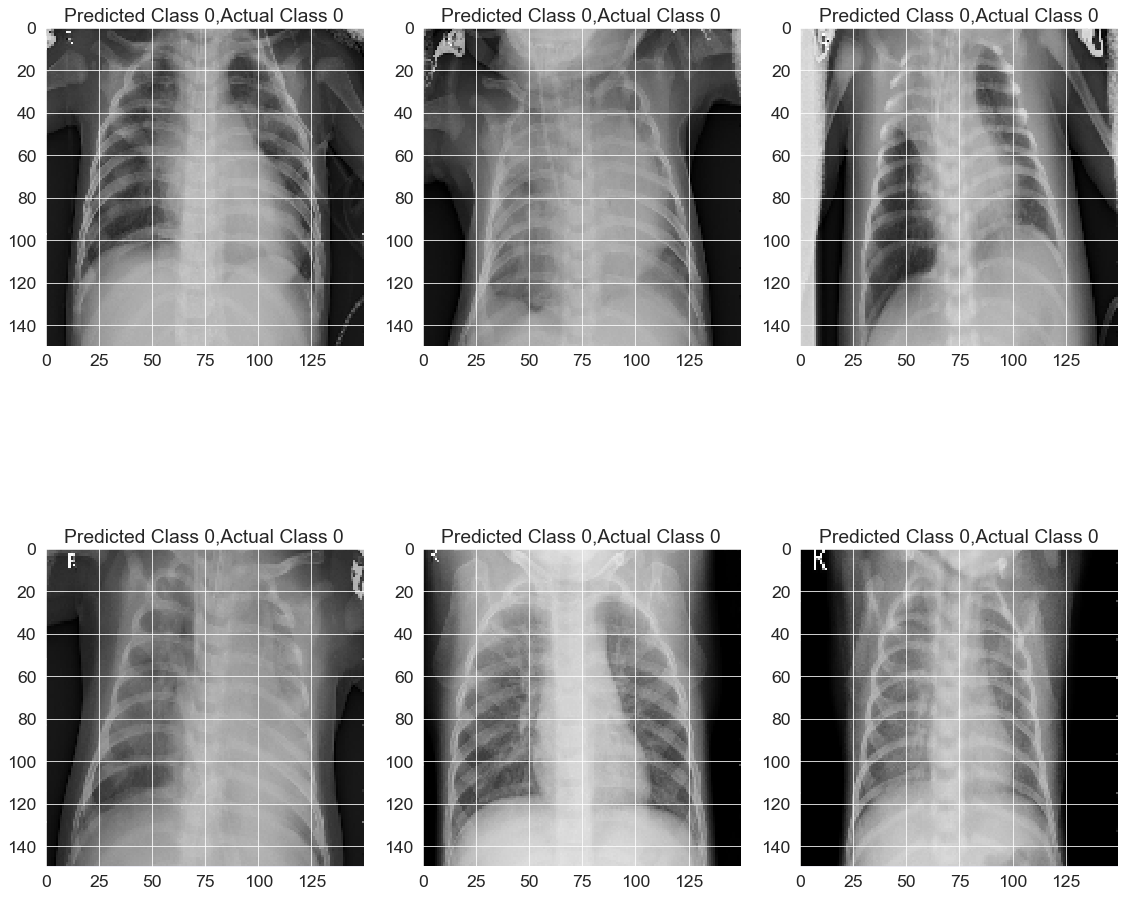

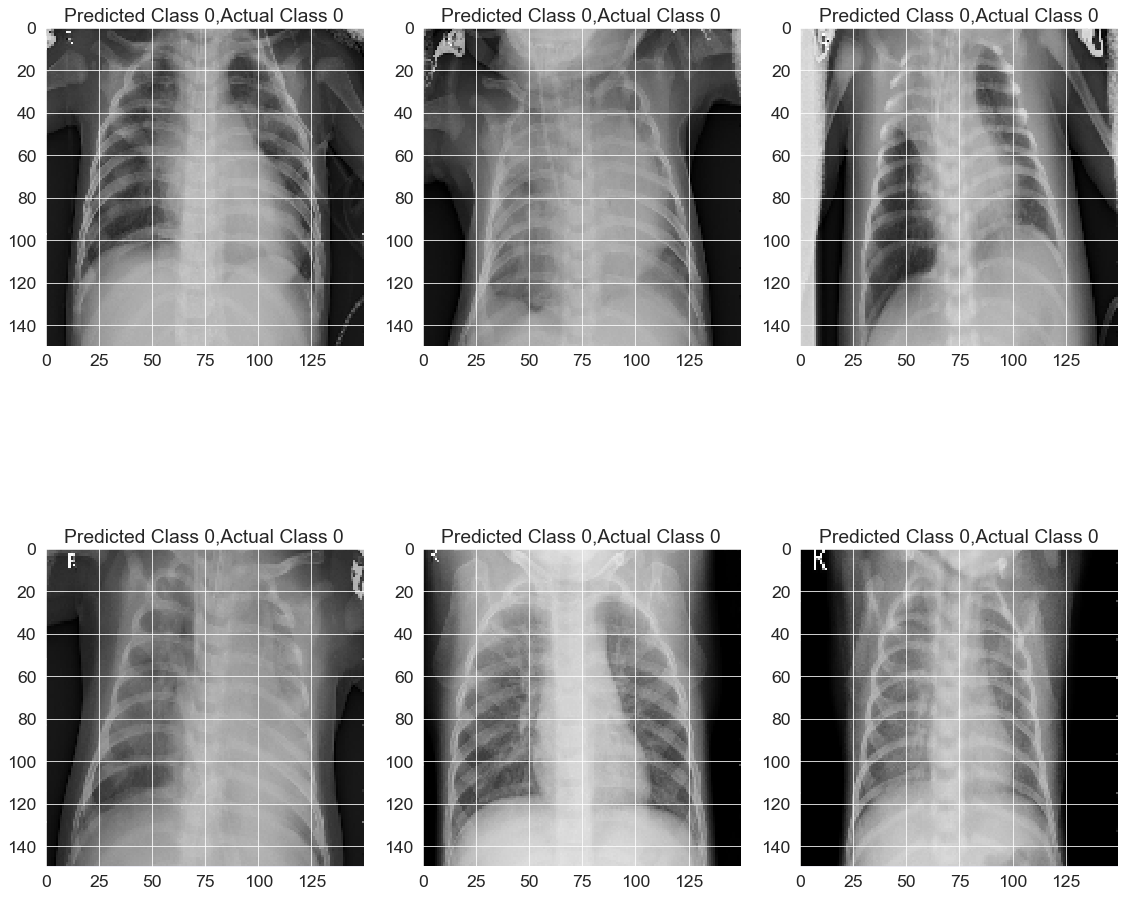

In [127]:
# Intantial cnn_model class and store all datasets inside the class
cnn  = cnn_model(X_train, y_train, X_test, y_test, X_val, y_val)
model = cnn.build_model([CONV2D_3x3_32, MAXPOOL_2D, CONV2D_3x3_64, MAXPOOL_2D, FLATTEN_LAYERS, DENSE_128, DROPOUT_20PERCENT])
history = cnn.fit_report_model("Model3_Epoch12_", 32, 12)

In [ ]:
#Model 4: Model 3 run with 50 Epochs..
# Intantial cnn_model class and store all datasets inside the class
cnn  = cnn_model(X_train, y_train, X_test, y_test, X_val, y_val)
model = cnn.build_model([CONV2D_3x3_32, MAXPOOL_2D, CONV2D_3x3_64, MAXPOOL_2D, FLATTEN_LAYERS, DENSE_128, DROPOUT_20PERCENT])
history = cnn.fit_report_model("Model3_Epoch12_", 32, 50)

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 92416)             0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               11829376  
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)             